In [38]:
import time
import random
import numpy as np

In [39]:
class Env():
    def __init__(self, length, height):
        # define the height and length of the map
        self.length = length
        self.height = height
        # define the agent's start position
        self.x = 0
        self.y = 0

    def render(self, frames=50):
        for i in range(self.height):
            if i == 0: # cliff is in the line 0
                line = ['S'] + ['x']*(self.length - 2) + ['T'] # 'S':start, 'T':terminal, 'x':the cliff
            else:
                line = ['.'] * self.length
            if self.x == i:
                line[self.y] = 'o' # mark the agent's position as 'o'
            print(''.join(line))
        print('\033['+str(self.height+1)+'A')  # printer go back to top-left 
        time.sleep(1.0 / frames)

    def step(self, action):
        """4 legal actions, 0:up, 1:down, 2:left, 3:right"""
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.x = min(self.length - 1, max(0, self.x + change[action][0]))
        self.y = min(self.height - 1, max(0, self.y + change[action][1]))

        states = [self.x, self.y]
        reward = -1
        terminal = False
        if self.y == 0: # if agent is on the cliff line "SxxxxxT"
            if self.x > 0: # if agent is not on the start position 
                terminal = True
                if self.x != self.length - 1: # if agent falls
                    reward = -100
        return reward, states, terminal

    def reset(self):
        self.x = 0
        self.y = 0

In [139]:
class Q_table():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        self.table = [0] * actions * length * height # initialize all Q(s,a) to zero
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha
        self.gamma = gamma

    def _index(self, a, x, y):
        """Return the index of Q([x,y], a) in Q_table."""
        return a * self.height * self.length + y * self.length + x

    def _epsilon(self,num_episode):
        # return 0.1
        # version for better convergence:
        # """At the beginning epsilon is 0.2,
        # after 300 episodes decades to 0.05,
        # and eventually go to 0."""
        return 20. / (num_episode + 100)

    def take_action(self, x, y, num_episode):
        rand_percentile = np.random.uniform(0, 1)
        if rand_percentile < self._epsilon(num_episode):
            # Exploration: Random Action
            return np.random.choice(self.actions)
        else:
            # Exploitation: Greedy Action
            actions_values = []
            for act in range(self.actions):
                actions_values.append(self.table[self._index(act, x, y)])
            return np.argmax(actions_values)



    def max_q(self, x, y):
        actions_value = [self.table[self._index(a, x, y)] for a in range(self.actions)]
        return max(actions_value)

    def update(self, a, s0, s1, r, is_terminated, num_episode, is_online):
        # both s0, s1 have the form [x,y]
        # s0 -> S, S1 -> S', r -> R
        # qsa -> Q(S, A)
        if is_online:
            # Sarsa
            qsa = self.table[self._index(a, s0[0], s0[1])]
            next_action = 0
            if is_terminated:
                td_target = r
            else:
                next_action = self.take_action(s1[0], s1[1], num_episode)
                td_target = r + self.gamma * self.table[self._index(next_action, s1[0], s1[1])]
            self.table[self._index(a, s0[0], s0[1])] += self.alpha * (td_target - qsa)
            return next_action
        else:
            # Q-learning
            qsa = self.table[self._index(a, s0[0], s0[1])]
            if is_terminated:
                td_target = r
            else:
                td_target = r + self.gamma * self.max_q(s1[0], s1[1])
            self.table[self._index(a, s0[0], s0[1])] += self.alpha * (td_target - qsa)

In [142]:
env = Env(length=12, height=4)
table = Q_table(length=12, height=4)

nums = []
rewards = []

is_online = True

for num_episode in range(3000):
    # within the whole learning process
    episodic_reward = 0
    is_terminated = False
    s0 = [0, 0]
    next_action = table.take_action(s0[0], s0[1], num_episode)
    while not is_terminated:
        # within one episode
        if is_online:
            action = next_action
        else:
            action = table.take_action(s0[0], s0[1], num_episode)
        r, s1, is_terminated = env.step(action)
        next_action = table.update(action, s0, s1, r, is_terminated, num_episode, is_online)
        episodic_reward += r
        # env.render(frames=100)
        s0 = s1
    if num_episode % 20 == 0:
        print("\r Episode: {}, Score: {}".format(num_episode, episodic_reward), end='')
    nums.append(num_episode)
    rewards.append(episodic_reward)
    env.reset()

oxxxxxxxxxxT
............
............
............

SoxxxxxxxxxT
............
............
............

SxoxxxxxxxxT
............
............
............

SxxoxxxxxxxT
............
............
............

SxxoxxxxxxxT
............
............
............

SxxoxxxxxxxT
............
............
............

SxoxxxxxxxxT
............
............
............

SoxxxxxxxxxT
............
............
............

oxxxxxxxxxxT
............
............
............

oxxxxxxxxxxT
............
............
............

oxxxxxxxxxxT
............
............
............

SxxxxxxxxxxT
o...........
............
............

 Episode: 0, Score: -111SoxxxxxxxxxT
............
............
............

oxxxxxxxxxxT
............
............
............

oxxxxxxxxxxT
............
............
............

oxxxxxxxxxxT
............
............
............

SxxxxxxxxxxT
o...........
............
............

oxxxxxxxxxxT
............
............
............

oxxxxxxxxxxT
.........

KeyboardInterrupt: 

In [47]:
def get_item(table, x, y):
    return [table.table[table._index(a, x, y)] for a in range(4)]

def way(dir):
    if dir == 0:
        return '⬆️'
    elif dir == 1:
        return '⬇️'
    elif dir == 2:
        return '⬅️'
    elif dir == 3:
        return '➡️'


## print_all_actions(table):


In [141]:
for y in range(env.height-1, -1, -1):
    for x in range(0, env.length):
        print(way(np.argmax(get_item(table, x, y))), end='')
    print()

➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️➡️⬇️
➡️➡️⬆️➡️⬆️➡️➡️➡️➡️➡️➡️⬇️
⬆️⬅️⬆️➡️⬆️⬆️➡️⬆️➡️➡️➡️⬇️
⬆️⬆️⬆️⬆️⬆️⬆️⬆️⬆️⬆️⬆️⬆️⬆️


In [125]:
get_item(table, 1, 0)

[0, 0, 0, 0]

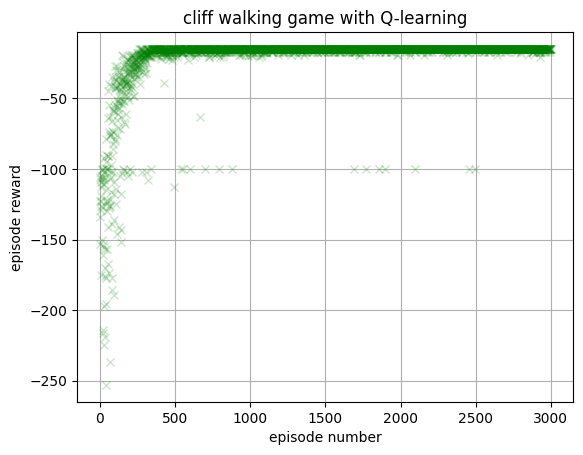

In [134]:
import matplotlib.pyplot as plt

plt.xlabel('episode number')
plt.ylabel('episode reward')
plt.title('cliff walking game with Q-learning')

plt.plot(nums, rewards, marker='x', color='g', linewidth=0, alpha=0.2)
plt.grid()

plt.show()